This is program STEGANOGRAPHY
Select your option:
 [1] - Use sample message and picture
 [2] - Choose your message and picture 
 [0] - Exit 
1
Message have been hided successfully - image saved to file  Coded_img.png


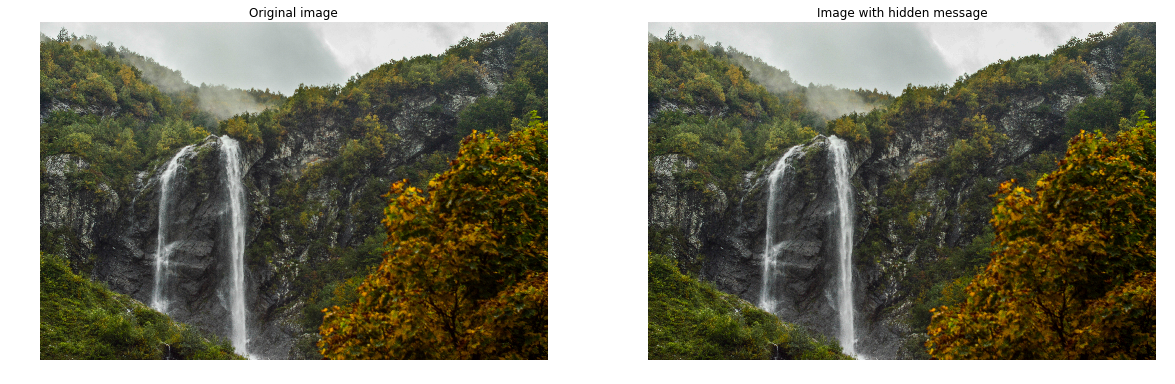

Do you want to decode the hidden message from image? Y / N 
y
Hidden message saved successfully to file  Output.txt


In [27]:
__author__ = 'Sofya Zubtsovsky & Roman Irinarhov'
%matplotlib inline

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

LSB = 2

menu_for_user()

In [16]:
def menu_for_user():
    img_path = 'water.png'
    msg_path = 'message.txt'
    print 'This is program STEGANOGRAPHY'
    option = -1
    while option < 0 or option > 2:
        try:
            option = int(raw_input(
                'Select your option:\n '
                '[1] - Use sample message and picture\n '
                '[2] - Choose your message and picture \n '
                '[0] - Exit \n'))

        except ValueError:
            option = -1
        if option == 2:
            ok_msg = False
            ok_img = False
            while ok_img is False:
                img_path = raw_input('Enter path to your pic\n')
                if os.path.exists(img_path):
                    ok_img = True
                else:
                    print 'Given path to image does not exist! Try another one'

            while ok_msg is False:
                msg_path = raw_input('Enter path to your message\n')
                if os.path.exists(msg_path):
                    ok_msg = True
                else:
                    print 'Given path to message does not exist! Try another one'
                    ok_msg = False
            encode(img_path, msg_path)

        elif option == 1:

            if os.path.exists(msg_path):
                ok_msg = True
            else:
                print "Can't find default message"
                ok_msg = False
                option = -1
            if os.path.exists(img_path):
                ok_img = True
            else:
                print "Can't find default image"
                ok_img = False
                option = -1
            if (ok_img and ok_msg):
                encode(img_path, msg_path)

        elif option == 0:
            return
        else:
            print 'Wrong option!\n'

In [24]:
def encode(img_path, msg_path):
    hidden = hide_msg(img_path, msg_path)
    
    if hidden is not None:
        show_result(img_path, hidden)
        decode = raw_input('Do you want to decode the hidden message from image? Y / N \n').lower()
        if decode == 'y':
            find_msg(hidden)

        else:
            return
    else:
        return

In [4]:
def hide_msg(img_path, msg_path):

    # open given image
    img = cv2.imread(img_path)
    if img is None:
        print "Can't open your image!"
        return None
    if img.__class__ != np.ndarray:
        print 'Wrong type of image!'
        return None

# check image dimension
    dim = len(img.shape)
    if dim == 3:
        layers = img.shape[2]
    elif dim == 2:
        layers = 1
    elif dim == 0:
        print 'Wrong image dimension!'
        return None

    orig_img = img.copy()

    # open given message
    f = open(msg_path, 'r')
    if f is None:
        print "Can't open your file!"
        return None

    msg = f.read().strip()
    if not msg:
        print "Your file doesn't contains a message to hide!"
        return None

    f.close()

    # convert msg to array of bits
    bit_msg = to_bit(msg)

    # prepare image to apply Canny
    msb_img = orig_img & 252

    canny = cv2.Canny(msb_img, 100, 200)

    # count the capacity of Canny mask
    capacity = np.count_nonzero(canny)

    h, w = orig_img.shape[0], orig_img.shape[1]

    # count the common capacity for image
    cap3d = capacity * layers * LSB

    # calculate ratio of playload
    ratio = cap3d * 1. / (h * w * 1.)

    pixel_need = np.int(np.sqrt(len(bit_msg) * 1. / ratio * 1.))

    # calculate necessary capacity for given message
    needed = cap3d - len(bit_msg)
    if needed < 0:
        print "Message can't be hide in this image!"
        print 'For this image max message size is ', cap3d * 1. / 8000, ' kilobytes'
        print 'And your message is                ', len(bit_msg) * 1. / 8000, ' kilobytes'
        print 'For this message you need picture with min size '
        print pixel_need, ' x ', pixel_need, ' pixels'
        print 'And your image is'
        print h, ' x ', w
        return None

    canny[canny != 0] = 1

    # unite to bit to pair of bits
    bit_msg = np.reshape(bit_msg, (-1, LSB))

    # convert 2 bit to 2-digit number
    int_msg = bit_msg[:, 0] << 1 | bit_msg[:, 1]

    # pad the given message to ND-mask sizes for each layers
    to_pad = layers * capacity - int(len(int_msg))
    padded = np.pad(int_msg, (0, to_pad), 'constant')
    my_split = np.split(padded, layers)

    # fill the mask with massage's bits
    mask3d = np.uint8(np.ndarray((canny.shape[0], canny.shape[1], layers)))
    for i in range(len(my_split)):
        mask3d[:, :, i][canny != 0] = my_split[i]

    # apply filled mask to image
    coded_img = msb_img | (mask3d & 3)

    # save image with hidden message
    path_save = 'Coded_img.png'
    cv2.imwrite(path_save, coded_img)
    print 'Message have been hided successfully - image saved to file ', path_save
    return coded_img

In [23]:
def find_msg(hidden):

    img = hidden.copy()
    if img is None:
        print "Can't open image to decode!"
        return None

    coded_img = img.copy()
    dim = len(img.shape)
    if dim == 3:
        layers = img.shape[2]
    elif dim == 2:
        layers = 1
    elif dim == 0:
        print 'Wrong image dimension!'
        return None

    # prepare image to apply Canny
    msb_img = coded_img & 252
    canny = cv2.Canny(msb_img, 100, 200)
    msg = []

    # pull off all the bits from mask indexes
    for i in range(layers):
        msg.extend(img[:, :, i][canny != 0] & 3)

    # covert bits to string
    final_msg = arr_to_str(np.asarray(msg))
    # save string to file
    path_to_save = 'Output.txt'
    text_file = open(path_to_save, "w")
    text_file.write(final_msg)
    text_file.close()
    print 'Hidden message saved successfully to file ', path_to_save

In [6]:
def arr_to_str(arr):  # convert array of pair of bits to string

    bits = []

    # split pair of bits to single bits
    for i in range(len(arr)):
        tmp = arr[i]
        bits.append(tmp >> 1 & 1)
        bits.append(tmp & 1)

    bits = np.asarray(bits)  # call the conversion function
    my_bytes = bit_to_byte(bits, 8)
    final_msg = "".join(map(chr, my_bytes))
    return final_msg

In [7]:
def bit_to_byte(l, n):  # convert array of bits to array of bytes

    my_bytes = []
    for i in xrange(0, len(l), n):
        tmp = l[i:i + n]
        curr_byte = 0
        for j in range(len(tmp)):
            curr_byte |= tmp[j] << j
        if(curr_byte==0):
            break
        my_bytes.append(curr_byte)
    return np.asarray(my_bytes)

In [8]:
def to_bit(msg):  # convert string to array of bits

    # convert string to int
    b_list = [ord(b) for b in msg]
    bits = []

    # convert int to bits
    for b in b_list:
        for i in xrange(8):
            bits.append((b >> i) & 1)
    return bits

In [26]:
def show_result(img_path, coded_img):
    img_in =  cv2.imread(img_path)
    
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.axis("off")
    plt.title("Original image")
    plt.imshow(img_in[:,:,::-1])
    plt.subplot(122)
    plt.axis("off")
    plt.title("Image with hidden message")
    plt.imshow(coded_img[:,:,::-1])
    plt.show()